# Load Data

In [3]:
# --- System and file handling ---
import os
import pandas as pd
import imageio

# --- Numerical and array operations ---
import numpy as np

# --- Raster handling ---
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

# --- Geo-spatial handling ---
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm

data_dir = "spei_yearly"

In [4]:
records = []

for file in os.listdir(data_dir):
    if file.endswith('.tif'):
        file_path = os.path.join(data_dir, file)
        with rasterio.open(file_path) as src:
            img = src.read(1)  # Read the first band
            records.append({
                'folder': data_dir,
                'file': file,
                'data': img
            })

df_tiffs = pd.DataFrame(records)


In [5]:
df_tiffs

,folder,file,data
0,spei_yearly,1993_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,spei_yearly,1994_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,spei_yearly,1995_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,spei_yearly,1996_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,spei_yearly,1997_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
5,spei_yearly,1998_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
6,spei_yearly,1999_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
7,spei_yearly,2000_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
8,spei_yearly,2001_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
9,spei_yearly,2002_12.tif,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."


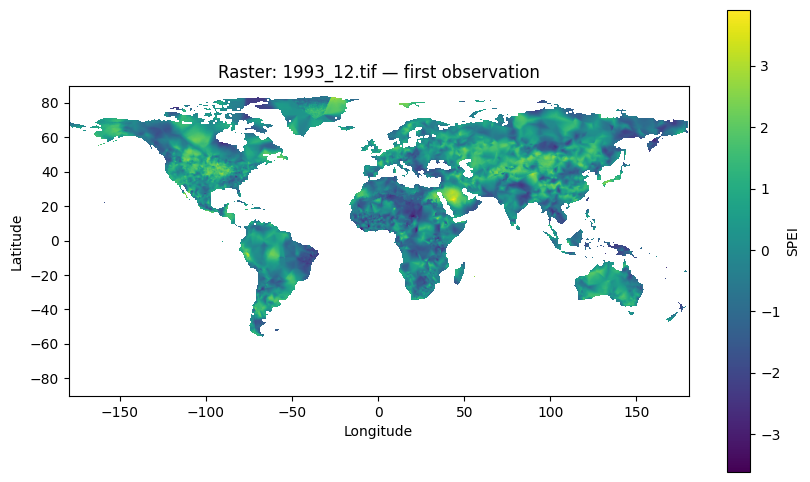

Raster geographic bounds (minx, maxx, miny, maxy): [-179.75, 180.25, -90.25, 89.75]


In [16]:
# --- Pick the first raster observation ---
first_row = df_tiffs.iloc[0]
img = first_row['data']
folder = first_row['folder']
file = first_row['file']
file_path = os.path.join(data_dir, file)

# --- Reopen raster to get transform and CRS ---
with rasterio.open(file_path) as src:
    transform = src.transform
    crs = src.crs
    # Compute geographic bounds
    h, w = src.height, src.width
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
    extent = [minx, maxx, miny, maxy]

# --- Mask invalid values ---
masked = np.ma.masked_invalid(img)

# --- Plot raster ---
plt.figure(figsize=(10, 6))
plt.imshow(masked, origin='upper', extent=extent, cmap='viridis')
plt.colorbar(label='SPEI')
plt.title(f"Raster: {file} — first observation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.show()

# --- Print raster extent info ---
print("Raster geographic bounds (minx, maxx, miny, maxy):", extent)


In [11]:
path_shapefile = "ethiopiashapefiles/Ethiopia_AdminBoundaries.shp"
gdf_admin2 = gpd.read_file(path_shapefile)

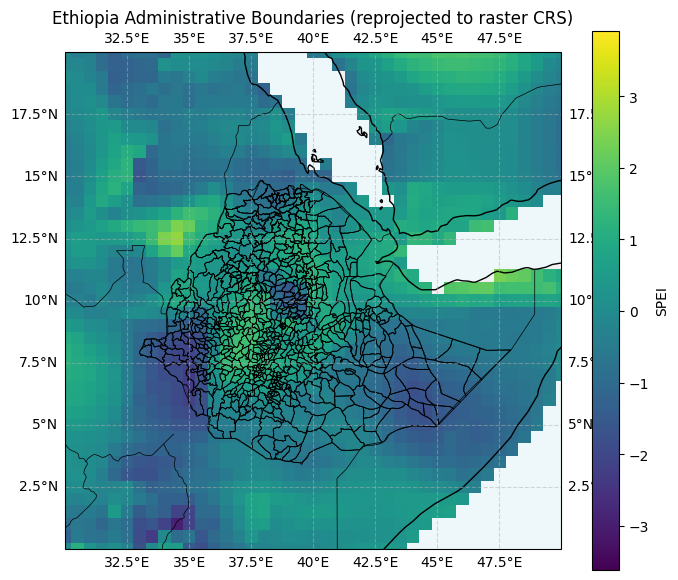

In [24]:
# Reproject admin boundaries to the raster CRS (WGS84) and plot
# (crs and gdf_admin2 are already defined in earlier cells)

target_crs = crs.to_string() if hasattr(crs, "to_string") else crs.wkt
gdf_wgs = gdf_admin2.to_crs(target_crs)

# Create a Cartopy GeoAxes and plot the raster and vector on it
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# --- Reopen raster to get transform and CRS ---
with rasterio.open(file_path) as src:
    transform = src.transform
    crs = src.crs
    # Compute geographic bounds
    h, w = src.height, src.width
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
    extent = [minx, maxx, miny, maxy]

# --- Mask invalid values ---
masked = np.ma.masked_invalid(img)

# Plot raster on the Cartopy GeoAxes (specify the data CRS)
im = ax.imshow(masked, origin='upper', extent=extent, cmap='viridis', transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, label='SPEI', orientation='vertical', shrink=0.7)

# Map features (works on a GeoAxes)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Plot administrative boundaries (already in WGS84) using cartopy's add_geometries
for geom in gdf_wgs.geometry:
    if geom is None:
        continue
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=0.6)

# Set a geographic extent (xmin, xmax, ymin, ymax) with the CRS
eth_extent = [30, 50, 0, 20]
ax.set_extent(eth_extent, crs=ccrs.PlateCarree())

ax.set_title("Ethiopia Administrative Boundaries (reprojected to raster CRS)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [26]:
from rasterio.features import geometry_mask

# Use the reprojected admin GeoDataFrame as districts
districts = gdf_wgs

# pick a sensible name column from the shapefile
name_col = next((c for c in ['WOREDANAME', 'WOREDANO_', 'name', 'Name', 'NAME'] if c in districts.columns), None)
if name_col is None:
    name_col = districts.columns[0]  # fallback

# Crop raster to Ethiopia extent (eth_extent = [xmin, xmax, ymin, ymax])
xmin, xmax, ymin, ymax = eth_extent
with rasterio.open(file_path) as src:
    window = from_bounds(xmin, ymin, xmax, ymax, src.transform)
    arr = src.read(1, window=window)
    transform_cropped = src.window_transform(window)

# Mask invalid values (convert to masked array)
masked_cropped = np.ma.masked_invalid(arr)

# Compute mean SPEI per district
district_means = []
for idx, row in districts.iterrows():
    geom = [row['geometry']]
    # select all pixels that touch the polygon by using all_touched=True
    mask = geometry_mask(geom, out_shape=masked_cropped.shape, transform=transform_cropped, invert=True, all_touched=True)
    vals = masked_cropped[mask].compressed()
    mean_value = np.nan if vals.size == 0 else float(vals.mean())
    district_means.append({'district_name': row[name_col], 'mean_spei': mean_value})

df_districts_spei = pd.DataFrame(district_means)
df_districts_spei.head()


,district_name,mean_spei
0,Nefas Silk,0.440606
1,Bole,0.863144
2,Lideta,0.863144
3,Kirkos,0.863144
4,Yeka,1.285683


In [ ]:
districts

In [ ]:
# Loop over all rasters and compute mean SPEI per district for each file
results = []

# use the same Ethiopia extent used before
xmin, xmax, ymin, ymax = eth_extent

for _, tif_row in df_tiffs.iterrows():
    tif_file = tif_row['file']
    tif_path = os.path.join(tif_row['folder'], tif_file)

    with rasterio.open(tif_path) as src:
        # crop to Ethiopia window and get window transform
        window = from_bounds(xmin, ymin, xmax, ymax, src.transform)
        arr = src.read(1, window=window)
        transform_cropped = src.window_transform(window)

    masked_cropped = np.ma.masked_invalid(arr)

    # compute mean for each district
    for _, drow in districts.iterrows():
        geom = [drow['geometry']]
        mask = geometry_mask(geom, out_shape=masked_cropped.shape, transform=transform_cropped,
                             invert=True, all_touched=True)
        vals = masked_cropped[mask].compressed()
        mean_value = np.nan if vals.size == 0 else float(vals.mean())
        results.append({
            'file': tif_file,
            'district_id': drow['WOREDANO_'],
            'district_name': drow[name_col],
            'mean_spei': mean_value
        })

# combined dataframe with all files x districts
df_all_districts_spei = pd.DataFrame(results)

# quick check
df_all_districts_spei.head()



,file,district_id,district_name,mean_spei
0,1993_12.tif,140102,Nefas Silk,0.440606
1,1993_12.tif,140104,Bole,0.863144
2,1993_12.tif,140105,Lideta,0.863144
3,1993_12.tif,140106,Kirkos,0.863144
4,1993_12.tif,140107,Yeka,1.285683


In [73]:
# extract 4-digit year from filename, drop original file column and move year to front
df_all_districts_spei['district_id'] = pd.to_numeric(df_all_districts_spei['district_id'], errors='coerce').astype('Int64')

df_all_districts_spei_final = df_all_districts_spei.copy()
df_all_districts_spei_final['year'] = df_all_districts_spei_final['file'].str.extract(r'(\d{4})')[0].astype(int)
df_all_districts_spei_final = df_all_districts_spei_final.drop(columns=['file'])
cols = ['year'] + [c for c in df_all_districts_spei_final.columns if c != 'year']
df_all_districts_spei_final = df_all_districts_spei_final[cols]
df_all_districts_spei_final = df_all_districts_spei_final.rename(columns={"district_id": "districtid"})  # match naming
df_all_districts_spei_final = df_all_districts_spei_final.dropna(subset=['districtid'])  # drop rows where districtid could not be converted
df_all_districts_spei_final["districtid"] = df_all_districts_spei_final["districtid"].astype(int)
df_all_districts_spei_final["year"] = df_all_districts_spei_final["year"].astype(int)
print(df_all_districts_spei_final.head())

   year  districtid district_name  mean_spei
0  1993      140102    Nefas Silk   0.440606
1  1993      140104          Bole   0.863144
2  1993      140105        Lideta   0.863144
3  1993      140106        Kirkos   0.863144
4  1993      140107          Yeka   1.285683


In [ ]:
# stata_df = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/full_datasets/full_traveltimes.dta")
# stata_df['districtid'] = stata_df['districtid'].astype(int)


# # merge on the integer district id
# merged = stata_df.merge(df_all_districts_spei_final, left_on='districtid', right_on='district_id', how='left', suffixes=('_stata','_admin'))

# print(f"stata rows: {len(stata_df)}, merged rows: {len(merged)}, matched: {merged['district_id'].notna().sum()}")
# merged.head()

stata rows: 646, merged rows: 14155, matched: 14122


,districtid,region,zone,district,km_1996,km_2014,aa_1996,aa_2014,tt_1996,tt_1998,...,tt_2004,tt_2006,tt_2008,tt_2010,tt_2012,tt_2014,year,district_id,district_name,mean_spei
0,10101,Tigray,North Western Zone,Tahtay Adiabo,243.160004,238.910004,1359.920044,1004.02002,542.960022,592.200012,...,264.369995,264.369995,264.369995,203.339996,202.770004,202.766998,1993.0,10101,Tahtay Adiyabo,-0.872306
1,10101,Tigray,North Western Zone,Tahtay Adiabo,243.160004,238.910004,1359.920044,1004.02002,542.960022,592.200012,...,264.369995,264.369995,264.369995,203.339996,202.770004,202.766998,1994.0,10101,Tahtay Adiyabo,-0.284023
2,10101,Tigray,North Western Zone,Tahtay Adiabo,243.160004,238.910004,1359.920044,1004.02002,542.960022,592.200012,...,264.369995,264.369995,264.369995,203.339996,202.770004,202.766998,1995.0,10101,Tahtay Adiyabo,-0.294181
3,10101,Tigray,North Western Zone,Tahtay Adiabo,243.160004,238.910004,1359.920044,1004.02002,542.960022,592.200012,...,264.369995,264.369995,264.369995,203.339996,202.770004,202.766998,1996.0,10101,Tahtay Adiyabo,-1.209883
4,10101,Tigray,North Western Zone,Tahtay Adiabo,243.160004,238.910004,1359.920044,1004.02002,542.960022,592.200012,...,264.369995,264.369995,264.369995,203.339996,202.770004,202.766998,1997.0,10101,Tahtay Adiyabo,-0.279910


In [ ]:
#Load agriculture data
agri_1996 = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/production1996.dta")
agri_1996['districtid'] = agri_1996['districtid'].astype(int)

agri_2004 = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/prod2004.dta")
agri_2004['districtid'] = agri_2004['districtid'].astype(int)

agri_2006 = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/prod2006.dta")
agri_2006['districtid'] = agri_2006['districtid'].astype(int)

agri_2008 = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/prod2008.dta")
agri_2008['districtid'] = agri_2008['districtid'].astype(int)

agri_2010 = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/prod2010.dta")
agri_2010['districtid'] = agri_2010['districtid'].astype(int)

agri_2012 = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/prod2012.dta")
agri_2012['districtid'] = agri_2012['districtid'].astype(int)

agri_2014 = pd.read_stata("195703-V1/ReplicationPackage/STATAFiles/production2014.dta")
agri_2014['districtid'] = agri_2014['districtid'].astype(int)

agri_list = [agri_1996, agri_2004, agri_2006, agri_2008, agri_2010, agri_2012, agri_2014]

import pandas as pd

# List of (year, dataframe) tuples
agri_dfs = [
    (1996, agri_1996),
    (2004, agri_2004),
    (2006, agri_2006),
    (2008, agri_2008),
    (2010, agri_2010),
    (2012, agri_2012),
    (2014, agri_2014)
]

# Clean column names (remove digits etc.)
for _, df in agri_dfs:
    df.columns = df.columns.str.replace(r'\d+', '', regex=True).str.strip()

# Add year variable and combine all years
for year, df in agri_dfs:
    df["year"] = year

agri_panel = pd.concat([df for _, df in agri_dfs], ignore_index=True)

# Optional: set panel index
agri_panel = agri_panel.set_index(["districtid", "year"]).sort_index()

# Inspect
print(agri_panel.head())
print(agri_panel.shape)

                         land        output      land_cer    output_cer  \
districtid year                                                           
10101      1996  4.549290e+01  6.631165e+04  4.018350e+01  4.907698e+04   
           2006  2.353967e+02  8.718829e+06  1.906734e+02  5.936293e+06   
           2008  1.907181e+02  9.842352e+05  1.414854e+02  4.801921e+05   
           2010  8.342153e+07  4.220951e+10  6.060816e+07  1.985687e+10   
           2012  1.916841e+02  1.101054e+06  1.256932e+02  7.022054e+05   

                 HH_cer  numfields  numfieldsfertilized  landall  
districtid year                                                   
10101      1996    45.0      296.0                 82.0      NaN  
           2006     NaN        NaN                342.0      NaN  
           2008     NaN        NaN                460.0      NaN  
           2010     NaN        NaN                500.0      NaN  
           2012     NaN        NaN                660.0      NaN  
(2707

In [80]:
agri_full = agri_panel.reset_index().merge(
    df_all_districts_spei_final,
    on=["districtid", "year"],
    how="left"  # use left join to keep all agri observations
)
agri_full.drop(columns=['HH_cer', 'numfields', 'landall'], inplace=True)  # drop redundant column
print(agri_full.head())

   districtid  year          land        output      land_cer    output_cer  \
0       10101  1996  4.549290e+01  6.631165e+04  4.018350e+01  4.907698e+04   
1       10101  2006  2.353967e+02  8.718829e+06  1.906734e+02  5.936293e+06   
2       10101  2008  1.907181e+02  9.842352e+05  1.414854e+02  4.801921e+05   
3       10101  2010  8.342153e+07  4.220951e+10  6.060816e+07  1.985687e+10   
4       10101  2012  1.916841e+02  1.101054e+06  1.256932e+02  7.022054e+05   

   numfieldsfertilized   district_name  mean_spei  
0                 82.0  Tahtay Adiyabo  -1.209883  
1                342.0  Tahtay Adiyabo  -0.308819  
2                460.0  Tahtay Adiyabo  -0.389223  
3                500.0  Tahtay Adiyabo  -1.514044  
4                660.0  Tahtay Adiyabo  -1.834530  


In [84]:
dupes = agri_full[agri_full.duplicated(subset=["districtid", "year"], keep=False)]
print(dupes.sort_values(["districtid", "year"]))

agri_full = (agri_full
    .groupby(["districtid", "year", "land", "output", "land_cer", "output_cer",
              "numfieldsfertilized", "district_name"], as_index=False)
    .agg({"mean_spei": "mean"})
)

      districtid  year          land        output      land_cer  \
2223       60405  1996  1.638579e+02  1.395386e+05  1.381004e+02   
2224       60405  1996  1.638579e+02  1.395386e+05  1.381004e+02   
2225       60405  2004  3.804604e+02  1.377407e+06  2.905270e+02   
2226       60405  2004  3.804604e+02  1.377407e+06  2.905270e+02   
2227       60405  2006  2.405417e+02  9.779270e+06  1.605398e+02   
2228       60405  2006  2.405417e+02  9.779270e+06  1.605398e+02   
2229       60405  2008  5.807889e+02  2.449239e+06  4.174274e+02   
2230       60405  2008  5.807889e+02  2.449239e+06  4.174274e+02   
2231       60405  2010  2.305608e+08  1.149083e+11  1.292630e+08   
2232       60405  2010  2.305608e+08  1.149083e+11  1.292630e+08   
2233       60405  2012  5.750691e+02  3.455589e+06  3.111766e+02   
2234       60405  2012  5.750691e+02  3.455589e+06  3.111766e+02   
2235       60405  2014  9.004301e+02  4.867181e+06  4.992331e+02   
2236       60405  2014  9.004301e+02  4.867181e+

In [85]:
agri_full.duplicated(subset=["districtid", "year"]).sum()


0

# Regression

In [86]:
agri_full = agri_full.set_index(["districtid", "year"]).sort_index()


In [87]:
print(agri_full[["land", "output", "mean_spei"]].describe())

# Optional: check extreme values
outliers = agri_full[(agri_full["land"] > 1e6) | (agri_full["output"] > 1e10)]
print(outliers)

               land        output    mean_spei
count  2.695000e+03  2.695000e+03  2695.000000
mean   9.827486e+06  1.122766e+10     0.199845
std    3.152216e+07  5.079977e+10     0.717776
min    0.000000e+00  0.000000e+00    -2.697121
25%    5.489085e+01  2.067113e+05    -0.170309
50%    1.086057e+02  7.074565e+05     0.251403
75%    2.263434e+02  5.023794e+06     0.626800
max    4.798320e+08  8.951507e+11     2.088735
                         land        output      land_cer    output_cer  \
districtid year                                                           
10101      2010  8.342153e+07  4.220951e+10  6.060816e+07  1.985687e+10   
10102      2010  1.498835e+08  3.899676e+10  1.440555e+08  3.599527e+10   
10103      2010  7.749828e+07  3.060316e+10  6.852439e+07  2.147556e+10   
10104      2010  4.372162e+07  1.593192e+10  3.786041e+07  1.145927e+10   
10105      2010  1.213777e+08  5.705637e+10  1.087136e+08  5.137460e+10   
...                       ...           ...         

In [94]:
agri_full_final = agri_full.copy()

In [95]:
import numpy as np

# Yield or productivity
agri_full_final["yield"] = agri_full_final["output"] / agri_full_final["land"]

# Log transforms (add 1 to avoid log(0))
agri_full_final["log_output"] = np.log(agri_full_final["output"] + 1)
agri_full_final["log_land"] = np.log(agri_full_final["land"] + 1)
agri_full_final["log_yield"] = np.log(agri_full_final["yield"] + 1)

# Example: land per fertilized field
agri_full_final["land_per_field"] = agri_full_final["land"] / agri_full_final["numfieldsfertilized"]

agri_full_final['cereal_share'] = agri_full_final['land_cer'] / agri_full_final['land']


In [ ]:
print(agri_full_final.head())
print(agri_full_final.describe())
agri_full_final

                         land        output      land_cer    output_cer  \
districtid year                                                           
10101      1996  4.549290e+01  6.631165e+04  4.018350e+01  4.907698e+04   
           2006  2.353967e+02  8.718829e+06  1.906734e+02  5.936293e+06   
           2008  1.907181e+02  9.842352e+05  1.414854e+02  4.801921e+05   
           2010  8.342153e+07  4.220951e+10  6.060816e+07  1.985687e+10   
           2012  1.916841e+02  1.101054e+06  1.256932e+02  7.022054e+05   

                 numfieldsfertilized   district_name  mean_spei         yield  \
districtid year                                                                 
10101      1996                 82.0  Tahtay Adiyabo  -1.209883   1457.626423   
           2006                342.0  Tahtay Adiyabo  -0.308819  37038.882497   
           2008                460.0  Tahtay Adiyabo  -0.389223   5160.680944   
           2010                500.0  Tahtay Adiyabo  -1.514044    50

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [113]:
from linearmodels.panel import PanelOLS

model = PanelOLS.from_formula(
    "log_yield ~ 1 + mean_spei + EntityEffects + TimeEffects",
    data=agri_full_final
)

results = model.fit(cov_type='clustered', cluster_entity=True)  # cluster at district level
print(results.summary)


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:              log_yield   R-squared:                        0.0044
Estimator:                   PanelOLS   R-squared (Between):              0.0355
No. Observations:                2692   R-squared (Within):               0.0046
Date:                 Di, Okt 28 2025   R-squared (Overall):              0.0081
Time:                        18:14:18   Log-likelihood                   -2045.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.057
Entities:                         401   P-value                           0.0015
Avg Obs:                       6.7132   Distribution:                  F(1,2284)
Min Obs:                       3.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             8.3783
                            

In [110]:
# statsmodels imports (numpy already imported in earlier cells)
import statsmodels.api as sm
import statsmodels.formula.api as smf

# reset index copy for modelling
agri_full_final_reset = agri_full_final.reset_index()

# 1️⃣ Prepare the data: avoid exact 0 or 1
eps = 1e-5
agri_full_final_reset['cereal_share_frac'] = agri_full_final_reset['cereal_share'].clip(eps, 1 - eps)

# Select only the variables used in the model (and the clustering id) and drop rows with any NA.
model_vars = ['cereal_share_frac', 'mean_spei', 'districtid']
data_model = agri_full_final_reset[model_vars].dropna()

if data_model.shape[0] == 0:
    raise ValueError("No rows left after dropping NA values in model variables. Check your data.")

# Build GLM on the cleaned dataframe so patsy doesn't drop rows unexpectedly.
glm_model = smf.glm(
    formula='cereal_share_frac ~ mean_spei',
    data=data_model,
    family=sm.families.Binomial(link=sm.families.links.logit())
)

# Now groups_array has exactly the same length as the data used by the model
groups_array = data_model['districtid'].values

glm_results = glm_model.fit(
    cov_type='cluster',
    cov_kwds={'groups': groups_array}
)

print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:      cereal_share_frac   No. Observations:                 2692
Model:                            GLM   Df Residuals:                     2690
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1015.8
Date:                 Di, 28 Okt 2025   Deviance:                       337.82
Time:                        18:02:35   Pearson chi2:                     345.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002686
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3264      0.035     38.364      0.0

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [111]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Select only variables used in the model and drop NAs
model_vars = ['cereal_share_frac', 'mean_spei', 'log_land', 'numfieldsfertilized', 'districtid', 'year']
data_model = agri_full_final_reset[model_vars].dropna()

# Build GLM with district and year fixed effects
glm_model = smf.glm(
    formula='cereal_share_frac ~ mean_spei + log_land + numfieldsfertilized + C(districtid) + C(year)',
    data=data_model,
    family=sm.families.Binomial(link=sm.families.links.logit())
)

# Clustered SEs at district level
groups_array = data_model['districtid'].values
glm_results = glm_model.fit(cov_type='cluster', cov_kwds={'groups': groups_array})

print(glm_results.summary())


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:      cereal_share_frac   No. Observations:                 2692
Model:                            GLM   Df Residuals:                     2282
Model Family:                Binomial   Df Model:                          409
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -897.28
Date:                 Di, 28 Okt 2025   Deviance:                       100.73
Time:                        18:06:05   Pearson chi2:                     96.0
No. Iterations:                     8   Pseudo R-squ. (CS):            0.08676
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 